**Project Overview**
- The goal of this project is to be be able to predict the rate/night for an Airbnb listing in Seattle.
- The dataset was taken from Kaggle, it contains 7576 observations, each of which is an Airbnb listing in Seattle. The details provided for each listing are -room_id, host_id, room_type, address, reviews, overall_satisfaction, accommodates, bedrooms, bathrooms, price, last_modified, latitude, longitude, location, name, currency, rate_type.
- Typically the numerical features that are available for each listing is used to build a predictive model using Linear Regression. I wanted to try something slightly differnt (and very challenging), I wanted to see if the model performance would improve if the text used int he "name" column, which is used to describe each listing, could be used to improve model performance.
- This is done by converting the text into a numerical feature and using that in addition to the existing features to see if the model performs better.
- I found a paper [link text](http://www-stat.wharton.upenn.edu/~stine/research/regressor.pdf) online that inspired me to work on this project. In this paper, the authors have tried to convert the decription of each real estate listing found on trulia.com into numerical features in order to predict the sale price of each listing. I have tried to mimick their approach, but have used a different data set.
- The basic approach for converting the text in the "name" column into numerical features is as follows:
-  A word count matrix is built, this will count the number of times each word appears in a listing.
 -   The Word Count Matrix  treats each listing as a bag of words, and ignores the order in which the words appear.
-   The truncated Singular Value Decompositions of this matrix will be calculated, this will be the additional regressor. The leading Singular Value Decompositions are then re-associated with each listing.
-  A bigram frequency matrix is built, this will tell you the number of times two works appear adjacent to one another.
 -   This matrix defines the context for each listing's description by placing importance on the adjacency.
-   Similar to above, the truncated Singular Value Decompositions are calculated and associated with each observation in the original data set.
- Both the word count matrix and bigram matrix will be used in this approach as they are a different way of looking at the texts in the descriptions.

**Linear Regression** will be the most appropriate model for this data set.

There will be several Linear Regression models built. They are explained below:
- Regression 1 - This will serve as the base model, and will provide a bench mark against which the models with additional regressors will be compared with. This model will include the numerical features that are available in the original data set, as well as a calculated feature - the number of characters in the "name" column. This is under the assumption that the airbnb listings in popular locations, or ones with newer properties with additional amenities will have a lengthier description when compared to the others.
- Regression 2 - This will include the features in Regression 1, along with the truncated leading **100** Singular Value Decompositions for the **word count matrix**. The number of leading SVDs to be included is a user input. Hence there will be versions that include more SVDs as well.
- Regression 3 - This will include the features in Regression 1, as well as top **250** leading SVDs for the **word count matrix.**
- Regression 4 - This will include the features in Regression 1, as well as top **500** leading SVDs for the **word count matrix.**
- Regression 5 - This includes features in Regression 1, along with SVDs for the **bigram frequency matrix**.
 - The method for associating the SVDs of the Bigram Matrix is slightly different than what was done with the word count matrix, hence there will be only one model where all the SVDs are converted into additional regressors.

The Packages neccessary for data manipulation, matrix calculations and building the linear regression models are imported below.

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import scipy
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from collections import Counter
from nltk import bigrams
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from scipy.sparse.linalg import svds, eigs
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from scipy.stats import mstats
import statsmodels.api as sm

In [2]:
raw_data = pd.read_csv('seattle_01.csv')

In [3]:
raw_data.head(3)

,Unnamed: 0,room_id,host_id,room_type,address,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,last_modified,latitude,longitude,location,name,currency,rate_type
0,0,2318,2536,Entire home/apt,"Seattle, WA, United States",21,5.0,8,4.0,2.5,250,2018-12-20 03:46:14.698548,47.610819,-122.290816,0101000020E6100000D449B6BA9C925EC0416326512FCE...,"Casa Madrona - Urban Oasis, 1 block from the P...",USD,nightly
1,1,3335,4193,Entire home/apt,"Seattle, WA, United States",1,NaN,4,2.0,1.0,100,2018-12-20 04:08:45.277643,47.529846,-122.275840,0101000020E61000006FBBD05CA7915EC04DF564FED1C3...,Sweet Seattle Urban Homestead 2 Bdr,USD,nightly
2,2,4291,35749,Private room,"Seattle, WA, United States",63,4.5,2,1.0,1.0,82,2018-12-20 03:04:19.861014,47.687801,-122.313427,0101000020E6100000BDAB1E300F945EC0FB93F8DC09D8...,Sunrise in Seattle Master Suite,USD,nightly


As mentioned above, the data set has 7576 listings (observations), and 19 features.

In [4]:
raw_data.shape

(7576, 18)

The decriptions for each listign is in the "name" column, this is extracted for further processing.

In [5]:
desc = raw_data['name']

Basic Text Processing - Converting the text in each observation into lower case, removing obvious punctuation (as these will not add value while building a predictive model), and stripping the descriptions of white space.

In [6]:
desc = desc.str.lower()

In [7]:
translator=str.maketrans('','',string.punctuation)
desc=desc.str.translate(translator)

In [8]:
desc = desc.str.replace('\d+', '')

In [9]:
desc = desc.str.strip()

The "cleaned" descriptions for each listing is then stored in a separate Dataframe.

In [10]:
desc_df = pd.Series.to_frame(desc)

In [11]:
desc_df.head()

,name
0,casa madrona urban oasis block from the park
1,sweet seattle urban homestead bdr
2,sunrise in seattle master suite
3,cozy studio min to downtown wifi
4,fab private seattle urban cottage


**Word Count Matrix**

- As mentioned above, the word count matrix counts the number of times each word appears in a listing. The dimension of the resulting matrix wil depend on the number of unique words found across all the listings.
- There are a total of 3,238 unique words that appear across all listings, the resulting matrix will be dimension 7,576 * 3,238.


In [12]:
vectorizer = CountVectorizer()

In [13]:
word_count = vectorizer.fit_transform(desc)

In [14]:
print(word_count.shape)

(7576, 3238)


After examining the words that appear across listings, it is evident that some of them are typos and others are unique words that appear in only one or two listings. We can remove words that appear only in one lisiting, as these will not add much value to the predictive model.

In [15]:
type(word_count)

scipy.sparse.csr.csr_matrix

Converting to data frame to drop columns that have rare words, and then converting back to a sparse matrix.

In [16]:
word_count_df = pd.DataFrame(word_count.toarray())

In [17]:
word_count_df = word_count_df[word_count_df.columns[word_count_df.sum()>1]]

In [18]:
word_count_df.shape

(7576, 1465)

With the rare words dropped, the number of unique words across all listings has dropped to 1,465 (nearly half of what it was previously). This will be converted back into a sparse matrix to ensure that matrix operations can be performed with ease.

In [19]:
word_count_matrix = scipy.sparse.csr_matrix(word_count_df.values)

In [20]:
word_count_matrix.shape

(7576, 1465)

**Bigram Frequency Matrix**

The Bigram Frequency Matrix tells you the number of times a pair of words appear adjacent to one another.

In [21]:
bigram_list = desc

In [22]:
type(bigram_list)

pandas.core.series.Series

In [23]:
bigram_list = bigram_list.to_string()

In [24]:
token = nltk.word_tokenize(bigram_list)

In [25]:
bigrams = nltk.bigrams(token)

In [26]:
fdist = nltk.FreqDist(bigrams)

Extracting the key and value pairs separately to reformat output into a dataframe/matrix

In [28]:
pair_df = pd.DataFrame(list(fdist.items()))

In [29]:
pair_df.columns = ['word_pair','freq']

In [30]:
word_pair_df = pd.DataFrame(pair_df['word_pair'].values.tolist(), index=pair_df.index)

In [31]:
word_pair_df.columns = ['word1','word2']

In [32]:
pair_df_2 = pd.concat([word_pair_df, pair_df['freq']], axis = 1)

In [33]:
pair_df_2_pivot = pair_df_2.pivot(index = 'word1', columns = 'word2', values = 'freq')

In [34]:
pair_df_2_pivot = pair_df_2_pivot.fillna(0)

In [35]:
bigram_freq_matrix = scipy.sparse.csr_matrix(pair_df_2_pivot.values)

In [36]:
print(bigram_freq_matrix.shape)

(11016, 11015)


**Data Processing for Linear Regression 1**

The original data set will have to be processed further to retain numberical explanatory variables, and convert the categorical variables into dummy variables.

In [37]:
raw_data.head(3)

,Unnamed: 0,room_id,host_id,room_type,address,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,last_modified,latitude,longitude,location,name,currency,rate_type
0,0,2318,2536,Entire home/apt,"Seattle, WA, United States",21,5.0,8,4.0,2.5,250,2018-12-20 03:46:14.698548,47.610819,-122.290816,0101000020E6100000D449B6BA9C925EC0416326512FCE...,"Casa Madrona - Urban Oasis, 1 block from the P...",USD,nightly
1,1,3335,4193,Entire home/apt,"Seattle, WA, United States",1,NaN,4,2.0,1.0,100,2018-12-20 04:08:45.277643,47.529846,-122.275840,0101000020E61000006FBBD05CA7915EC04DF564FED1C3...,Sweet Seattle Urban Homestead 2 Bdr,USD,nightly
2,2,4291,35749,Private room,"Seattle, WA, United States",63,4.5,2,1.0,1.0,82,2018-12-20 03:04:19.861014,47.687801,-122.313427,0101000020E6100000BDAB1E300F945EC0FB93F8DC09D8...,Sunrise in Seattle Master Suite,USD,nightly


**room_type** and **rate_type** appear to be categorical variables.

In [38]:
raw_data.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [39]:
raw_data.rate_type.unique()

array(['nightly'], dtype=object)

- **rate_type** takes just one value, hence it is not useful as an explanatory variable, and it can be dropped. 
- In the case of room_type, the possible values - Entire home/apt, Private room and Shared room will have to be converted into numerical values. Other featuers containing text data will also be dropped.
- In terms of features that can be added from the above, desc_length can be added, which counts the number of characters in the name(listing description) column. This is based on the assumption that more favorable listings (in better locations, newer/better homes/apartments) would have a more detailed explanation as opposed to listings in less desirable neighborhoods.

In [40]:
raw_data['desc_length'] = raw_data['name'].str.len()

In [41]:
raw_data.head(3)

,Unnamed: 0,room_id,host_id,room_type,address,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,last_modified,latitude,longitude,location,name,currency,rate_type,desc_length
0,0,2318,2536,Entire home/apt,"Seattle, WA, United States",21,5.0,8,4.0,2.5,250,2018-12-20 03:46:14.698548,47.610819,-122.290816,0101000020E6100000D449B6BA9C925EC0416326512FCE...,"Casa Madrona - Urban Oasis, 1 block from the P...",USD,nightly,50
1,1,3335,4193,Entire home/apt,"Seattle, WA, United States",1,NaN,4,2.0,1.0,100,2018-12-20 04:08:45.277643,47.529846,-122.275840,0101000020E61000006FBBD05CA7915EC04DF564FED1C3...,Sweet Seattle Urban Homestead 2 Bdr,USD,nightly,35
2,2,4291,35749,Private room,"Seattle, WA, United States",63,4.5,2,1.0,1.0,82,2018-12-20 03:04:19.861014,47.687801,-122.313427,0101000020E6100000BDAB1E300F945EC0FB93F8DC09D8...,Sunrise in Seattle Master Suite,USD,nightly,31


In [42]:
data_1 = raw_data.drop(columns = ['address','last_modified','location','name','currency','rate_type','Unnamed: 0'])

In [43]:
data_1['entire_home'] = np.where(data_1['room_type'] == 'Entire home/apt', 1, 0)

In [44]:
data_1['private_room'] = np.where(data_1['room_type'] == 'Private room', 1, 0)

In [45]:
data_1['shared_room'] = np.where(data_1['room_type'] == 'Shared room', 1, 0)

In [46]:
data_1 = data_1.fillna(0)

In [47]:
data_1 = data_1.drop(columns = ['room_id','host_id','room_type'])

In [48]:
data_1.head()

,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,latitude,longitude,desc_length,entire_home,private_room,shared_room
0,21,5.0,8,4.0,2.5,250,47.610819,-122.290816,50,1,0,0
1,1,0.0,4,2.0,1.0,100,47.529846,-122.275840,35,1,0,0
2,63,4.5,2,1.0,1.0,82,47.687801,-122.313427,31,0,1,0
3,462,5.0,2,0.0,1.0,49,47.523980,-122.359891,35,1,0,0
4,134,4.5,2,1.0,1.0,90,47.654109,-122.337605,35,1,0,0


In [49]:
data_x = data_1.loc[:, data_1.columns != 'price']

{'whiskers': [<matplotlib.lines.Line2D at 0x25367eb8898>,
 'caps': [<matplotlib.lines.Line2D at 0x25367eb8da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x25367eb8320>],
 'medians': [<matplotlib.lines.Line2D at 0x25367ec6978>],
 'fliers': [<matplotlib.lines.Line2D at 0x25367ec6da0>],
 'means': []}

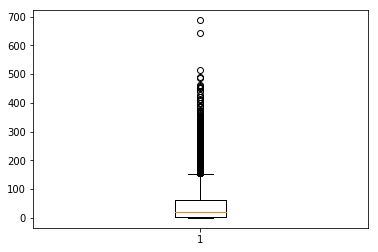

In [50]:
pyplot.boxplot(data_x['reviews'])

Since the range of values for the number of reviews is high, the outliers will need to be removed.

In [51]:
winsorize_reviews = scipy.stats.mstats.winsorize(data_x['reviews'],limits = 0.10)

In [52]:
winsorize_reviews_df = pd.DataFrame(winsorize_reviews)

In [53]:
winsorize_reviews_df.columns = ['reviews_2']

In [54]:
data_x = data_x.drop(columns = ['reviews'])

In [55]:
data_x = pd.concat([data_x, winsorize_reviews_df], axis = 1)

In [56]:
data_x.head()

,overall_satisfaction,accommodates,bedrooms,bathrooms,latitude,longitude,desc_length,entire_home,private_room,shared_room,reviews_2
0,5.0,8,4.0,2.5,47.610819,-122.290816,50,1,0,0,21
1,0.0,4,2.0,1.0,47.529846,-122.275840,35,1,0,0,1
2,4.5,2,1.0,1.0,47.687801,-122.313427,31,0,1,0,63
3,5.0,2,0.0,1.0,47.523980,-122.359891,35,1,0,0,133
4,4.5,2,1.0,1.0,47.654109,-122.337605,35,1,0,0,133


- The values in the Longitude and Latitude column cannot be used as is in Linear Regression. We can employ Clustering algorithms to convert the continuos values into categorical values, and use those in model instead.
- The goal is to ensure that the clusters are similar in size, and this is obtained by trail and error.

In [57]:
co_ord = pd.concat([data_x['latitude'],data_x['longitude']],axis = 1)

In [58]:
co_ord.head()

,latitude,longitude
0,47.610819,-122.290816
1,47.529846,-122.275840
2,47.687801,-122.313427
3,47.523980,-122.359891
4,47.654109,-122.337605


In [59]:
kmeans = KMeans(n_clusters=4, random_state=123).fit(co_ord)

In [60]:
result = kmeans.labels_

In [61]:
(result == 0).sum()

2369

In [62]:
(result == 1).sum()

1147

In [63]:
(result == 2).sum()

759

In [64]:
(result == 3).sum()

3301

- The greater the number of clusters, the imbalance in their size was more. Around 3-4 clusters had clusters that were mostly similar in size.
- The Latitude and Longitude columns will be dropped and repalced with a cluster_no column, indicating which cluster the listing belonged to.

In [65]:
cluster_no = pd.DataFrame(result)

In [66]:
cluster_no.columns = ['cluster_no']

In [67]:
data_x = data_x.drop(columns = ['latitude','longitude'])

In [68]:
data_x = pd.concat([data_x,cluster_no], axis = 1)

In [69]:
data_x['cluster_0']= np.where(data_x['cluster_no']==0, 1, 0)

In [70]:
data_x['cluster_1']= np.where(data_x['cluster_no']==1, 1, 0)

In [71]:
data_x['cluster_2']= np.where(data_x['cluster_no']==2, 1, 0)

In [72]:
data_x['cluster_3']= np.where(data_x['cluster_no']==3, 1, 0)

In [73]:
data_x = data_x.drop(columns = ['cluster_no'])

In [74]:
data_y = data_1['price']

In [75]:
data_y.min()

15

In [76]:
data_y.max()

5900

{'whiskers': [<matplotlib.lines.Line2D at 0x253002d7630>,
 'caps': [<matplotlib.lines.Line2D at 0x253002d7e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x253002d70b8>],
 'medians': [<matplotlib.lines.Line2D at 0x253002e2710>],
 'fliers': [<matplotlib.lines.Line2D at 0x253002e2b38>],
 'means': []}

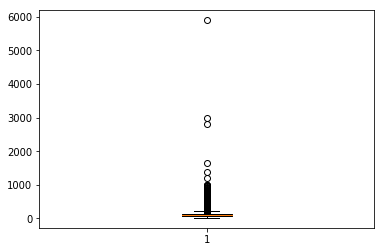

In [77]:
pyplot.boxplot(data_y)

Since the range of the values for the rate/night is from $ 15 - $ 5,900, the values should be scaled/normalized to ensure that the model performs optimally.

In [78]:
data_y = np.log(data_y)

**data_x** contains the explanatory variables and **data_y** contains the values that are to be predicted.

**Linear Regression 1**

Splitting the data into Training and Test (80%,20%)
data_x contains the explanatory variables, and data_y contains the values to be predicted (rate/night)

In [79]:
x1_train, x1_test, y1_train, y1_test = train_test_split(data_x, data_y, test_size=0.30, random_state=42)

In [80]:
x1_train.shape

(5303, 13)

In [81]:
x1_test.shape

(2273, 13)

The initial data set of 7576 observations has been randomly split into 5303 observations for training and 2273 observations ofr testing.

In [82]:
regression_1 = linear_model.LinearRegression()

In [83]:
regression_1.fit(x1_train, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [84]:
y1_pred = regression_1.predict(x1_test)

In [85]:
explained_variance_regression1 = explained_variance_score(y1_test, y1_pred) 

In [86]:
explained_variance_regression1

0.48862379021972224

In [87]:
regression1 = sm.OLS(data_y, data_x)

In [88]:
regression1_fit = regression1.fit()

In [89]:
print(regression1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     712.8
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        21:57:45   Log-Likelihood:                -4213.6
No. Observations:                7576   AIC:                             8451.
Df Residuals:                    7564   BIC:                             8534.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
overall_satisfaction     0.0061 

- The R Square for the **base model** is 51%, we shall see if adding additional regressors will help improve the performance.
- Most of the co-efficients have low P values, which makes them significant. However, let us drop overall_satisfaction and see if there is an improvement in performance.

data_x after dropping "overall_satisfaction" variable.

In [90]:
data_x_without_overall_satisfaction = data_x.drop(columns = ['overall_satisfaction'])

**Regression 1 after "overall_satisfaction" was dropped**

In [91]:
regression1_v2 = sm.OLS(data_y, data_x_without_overall_satisfaction)

In [92]:
regression1_v2_fit = regression1_v2.fit()

In [93]:
print(regression1_v2_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     783.3
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        21:57:45   Log-Likelihood:                -4215.9
No. Observations:                7576   AIC:                             8454.
Df Residuals:                    7565   BIC:                             8530.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
accommodates     0.0208      0.004      5.241   

The R Squared value remains the same, hence the base regression metric remains 51%, let us see if adding additional regressors results in an improved performance.

**Leading 100 Singular Value Decompositions for Word Count Matrix**

In [94]:
word_count_matrix.shape

(7576, 1465)

In [95]:
svd_word_count_matrix_100 = TruncatedSVD(n_components=100, n_iter=7, random_state=42)

In [96]:
svd_word_count_matrix_100.fit(word_count_matrix)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=7,
       random_state=42, tol=0.0)

In [97]:
print(svd_word_count_matrix_100.explained_variance_ratio_.sum())

0.6890017034317834


The leading 100 SVDs for the word count matrix explain 68% of the variance.

In [98]:
singular_values_100 = svd_word_count_matrix_100.singular_values_

**Building Regressors from the Leading 100 SVDs for the Word Count Matrix**

In order to draw a connection between the leading 100 SVDs and the observations, they will have to be mapped to one another. Each listing will need to be located within each of the SVDs. This is done by using the following formula:
- (Word Count for each Listing)* (Singular Values)/Count of words for listing

The above calculation will be performed for each listing, resulting in each listing getting an additional regressor.

In [99]:
no_token = data_1['desc_length']

In [100]:
word_count_matrix.shape

(7576, 1465)

In [101]:
singular_values_100.shape

(100,)

In [102]:
no_token.shape

(7576,)

Since the length of singular_value_100 is lesser than the number of columns in the word_count_matrix, the singular_value_100 vector will have to "padded" to ensure that they can be multiplied.

In [103]:
singular_values_100 = np.pad(singular_values_100,( 0, 1365),mode = 'symmetric')

In [104]:
singular_values_100.shape

(1465,)

In [105]:
regressors_svd_word_count_100 =  word_count_matrix.dot(singular_values_100)

In [106]:
regressors_svd_word_count_100 = regressors_svd_word_count_100/no_token

In [107]:
regressors_svd_word_count_100 = regressors_svd_word_count_100.to_frame()

In [108]:
regressors_svd_word_count_100.columns = ['svd_word_count_100_regressors']

In [109]:
regression_svd_word_count_data = pd.concat([regressors_svd_word_count_100,data_x], axis = 1)

**Building Regressors from the Leading 250 SVDs for the Word Count Matrix**

In [110]:
svd_word_count_matrix_250 = TruncatedSVD(n_components=250, n_iter=7, random_state=42)

In [111]:
svd_word_count_matrix_250.fit(word_count_matrix)

TruncatedSVD(algorithm='randomized', n_components=250, n_iter=7,
       random_state=42, tol=0.0)

In [112]:
print(svd_word_count_matrix_250.explained_variance_ratio_.sum())

0.8464616195981476


In [113]:
singular_values_250 = svd_word_count_matrix_250.singular_values_

In [114]:
singular_values_250 = np.pad(singular_values_250,( 0, 1215),mode = 'symmetric')

In [115]:
regressors_svd_word_count_250 =  word_count_matrix.dot(singular_values_250)

In [116]:
regressors_svd_word_count_250 = regressors_svd_word_count_250/no_token

In [117]:
regressors_svd_word_count_250 = regressors_svd_word_count_250.to_frame()

In [118]:
regressors_svd_word_count_250.columns = ['svd_word_count_250_regressors']

In [119]:
regression_svd_word_count_data_250 = pd.concat([regressors_svd_word_count_250,data_x], axis = 1)

**Building Regressors from the Leading 500 SVDs for the Word Count Matrix**

In [120]:
svd_word_count_matrix_500 = TruncatedSVD(n_components=500, n_iter=7, random_state=42)

In [121]:
svd_word_count_matrix_500.fit(word_count_matrix)

TruncatedSVD(algorithm='randomized', n_components=500, n_iter=7,
       random_state=42, tol=0.0)

In [122]:
print(svd_word_count_matrix_500.explained_variance_ratio_.sum())

0.9308079988309961


In [123]:
singular_values_500 = svd_word_count_matrix_500.singular_values_

In [124]:
singular_values_500 = np.pad(singular_values_500,( 0, 965),mode = 'symmetric')

In [125]:
regressors_svd_word_count_500 =  word_count_matrix.dot(singular_values_500)

In [126]:
regressors_svd_word_count_500 = regressors_svd_word_count_500/no_token

In [127]:
regressors_svd_word_count_500 = regressors_svd_word_count_500.to_frame()

In [128]:
regressors_svd_word_count_500.columns = ['svd_word_count_500_regressors']

In [129]:
regression_svd_word_count_data_500 = pd.concat([regressors_svd_word_count_500,data_x], axis = 1)

**Regression 2**

Features used in Regression 1, along with the regressors derived from the leading 100 SVDs for the Word Count Matrix.

Creating Training and Test Data (80%,20%)

In [130]:
x2_train, x2_test, y2_train, y2_test = train_test_split(regression_svd_word_count_data, data_y, test_size=0.30, random_state=42)

In [131]:
regression_2 = linear_model.LinearRegression()

In [132]:
regression_2.fit(x2_train, y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [133]:
y2_pred = regression_2.predict(x2_test)

In [134]:
explained_variance_regression2 = explained_variance_score(y2_test, y2_pred) 

In [135]:
explained_variance_regression2

0.488451421563576

In [136]:
regression2 = sm.OLS(data_y, regression_svd_word_count_data)

In [137]:
regression2_fit = regression2.fit()

In [138]:
print(regression2_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     653.3
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        21:58:06   Log-Likelihood:                -4213.6
No. Observations:                7576   AIC:                             8453.
Df Residuals:                    7563   BIC:                             8543.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
svd_word_count

While the R Square remains more or less the same, the P value for the svd_word_count_100_regressors variable is very high, indicating that the additional regressor is not helpful. Let's see if adding more than the top 100 SVD's will improve model performance.

**Regression 3**

Features used in Regression 1, along with regressors derived from leading 250 SVDs for the Word Count Matrix.

Creating Training and Test Data

In [139]:
x3_train, x3_test, y3_train, y3_test = train_test_split(regression_svd_word_count_data_250, data_y, test_size=0.30, random_state=42)

In [140]:
regression_3 = linear_model.LinearRegression()
regression_3.fit(x3_train, y3_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [141]:
y3_pred = regression_3.predict(x3_test)

In [142]:
print('R Square for Regression 3: %.2f' % r2_score(y3_test, y3_pred))

R Square for Regression 3: 0.49


In [143]:
explained_variance_regression3 = explained_variance_score(y3_test, y3_pred) 

In [144]:
explained_variance_regression3

0.48848306529347896

In [145]:
regression3 = sm.OLS(data_y, regression_svd_word_count_data_250)

In [146]:
regression3_fit = regression3.fit()

In [147]:
print(regression3_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     654.0
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        21:58:07   Log-Likelihood:                -4211.5
No. Observations:                7576   AIC:                             8449.
Df Residuals:                    7563   BIC:                             8539.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
svd_word_count

The P value for the svd_word_count_250_regressors variable is defintely much better than what it was in Regression 2. Adding more leading SVD seems to have a position effect to the model, let's see if thsi trend continues.

**Regression 4**

Features used in Regression 1, along with regressors derived from leading 500 SVDs for the Word Count Matrix.

In [148]:
x4_train, x4_test, y4_train, y4_test = train_test_split(regression_svd_word_count_data_500, data_y, test_size=0.30, random_state=42)

In [149]:
regression_4 = linear_model.LinearRegression()
regression_4.fit(x4_train, y4_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [150]:
y4_pred = regression_4.predict(x4_test)

In [151]:
print('R Square for Regression 4: %.2f' % r2_score(y4_test, y4_pred))

R Square for Regression 4: 0.49


In [152]:
explained_variance_regression4 = explained_variance_score(y4_test, y4_pred) 

In [153]:
regression4 = sm.OLS(data_y, regression_svd_word_count_data_500)

In [154]:
regression4_fit = regression4.fit()

In [155]:
print(regression4_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     654.5
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        21:58:07   Log-Likelihood:                -4210.2
No. Observations:                7576   AIC:                             8446.
Df Residuals:                    7563   BIC:                             8537.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
svd_word_count

**Adding more leading SVDs appears to have a positive effect, the P value for the svd_word_count_500_regressors variable is fairly low, which leads to the conclusion that it is am impactful explanatory variable to have in the model. Let us see if adding regressors from the Bigram Matrix has a similar effect in the model.**

**Singular Value Decomposition of Bigram Matrix**

In [156]:
bigram_freq_matrix.shape

(11016, 11015)

In [157]:
bigram_freq_svd = TruncatedSVD(n_components=1465, n_iter=7, random_state=42)

In [158]:
bigram_freq_svd.fit(bigram_freq_matrix)

TruncatedSVD(algorithm='randomized', n_components=1465, n_iter=7,
       random_state=42, tol=0.0)

In [159]:
print(bigram_freq_svd.explained_variance_ratio_.sum())

0.9986435138288217


In [160]:
bigram_freq_svd_values = bigram_freq_svd.singular_values_

In [161]:
bigram_freq_svd_values.shape

(1465,)

In [162]:
correlation_bigram_word_count = word_count_matrix.dot(bigram_freq_svd_values)

In [163]:
type(correlation_bigram_word_count)

numpy.ndarray

In [164]:
correlation_bigram_word_count = correlation_bigram_word_count.reshape(-1,1)

In [165]:
transformer = RobustScaler().fit(correlation_bigram_word_count)

In [166]:
correlation_bigram_word_count = transformer.transform(correlation_bigram_word_count)

In [167]:
correlation_bigram_word_count_df = pd.DataFrame(correlation_bigram_word_count)

In [168]:
correlation_bigram_word_count_df.columns = ['bigram_regressor']

In [169]:
correlation_bigram_word_count_df.head(3)

,bigram_regressor
0,0.145244
1,-0.013569
2,-0.381630


Building the Training data, joining data_x with the regressors derived from the SVDs of the Bigram Matrix.

In [170]:
data_bigram_regressor = pd.concat([data_x,correlation_bigram_word_count_df], axis = 1)

In [171]:
data_bigram_regressor.head()

,overall_satisfaction,accommodates,bedrooms,bathrooms,desc_length,entire_home,private_room,shared_room,reviews_2,cluster_0,cluster_1,cluster_2,cluster_3,bigram_regressor
0,5.0,8,4.0,2.5,50,1,0,0,21,0,0,0,1,0.145244
1,0.0,4,2.0,1.0,35,1,0,0,1,0,1,0,0,-0.013569
2,4.5,2,1.0,1.0,31,0,1,0,63,1,0,0,0,-0.381630
3,5.0,2,0.0,1.0,35,1,0,0,133,0,1,0,0,-0.237121
4,4.5,2,1.0,1.0,35,1,0,0,133,1,0,0,0,-0.290546


**Linear Regression 5**

In [172]:
x5_train, x5_test, y5_train, y5_test = train_test_split(data_bigram_regressor, data_y, test_size=0.30, random_state=42)

In [173]:
regression_5 = linear_model.LinearRegression()
regression_5.fit(x5_train, y5_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [174]:
y5_pred = regression_5.predict(x5_test)

In [175]:
print('R Square for Regression 5: %.2f' % r2_score(y5_test, y5_pred))

R Square for Regression 5: 0.49


In [176]:
explained_variance_regression5 = explained_variance_score(y5_test, y5_pred) 

In [177]:
regression5 = sm.OLS(data_y, data_bigram_regressor)

In [178]:
regression5_fit = regression5.fit()

In [179]:
print(regression5_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     653.5
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:00:39   Log-Likelihood:                -4212.9
No. Observations:                7576   AIC:                             8452.
Df Residuals:                    7563   BIC:                             8542.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
overall_satisfaction     0.0062 

While the P value for the bigram_regressor isn't as high as the P value in Regression 2, it certainly doesn't seem like a valuable addition to the model.

**In conclusion, yes, adding regressors from the text found in the listing's description is certainly a valuable addition. The SVDs from the Word Count Matrix with leading 500 SVDs was the most impactful, as it had a negligible P value.**

- In case of Regression 4, the P value for the additional regressor was quite low, and that is definitely a good sign, however the R square for the models remained unchanged. 
- What are additional steps that can be done to improve the R square values?
 - Cross Validation - Since the data set had only ~7500 observations, it is a fairly small data set. Holding out 30% of those observations to evaulate the model means that there isn't enough data to train the model properly. Cross validation could have resulted in more data for the model to be trained on.
 - Additional features - In the initial data set, prior to any data cleaning, there were 2 features called host_id and room_id. Host_id is to identify a host, and room_id to identify each listing. It is possible that each host could have multiple lisitngs, and adding the number of listings for each host could have been that could have improved the model as well.